In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Get Best Run of One Job

#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]
study_id = "ep"
save_csv = False

#Define Criteria
criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "a",
                 "retrain_GP": 10,
                 "num_x_data": 5,
                 "num_val_pts": 0,
                 "sep_fact": 1.0,
                 "meth_name_val": 5,
                 "lenscl": None}

#Get Jobs that match that criteria
project = signac.get_project()
jobs = sorted(project.find_jobs(criteria_dict), key=lambda job: job._id)

#Get the best information csv from those jobs
for job in jobs:
    path_name = job.fn("ep_study_best_all.csv")
    if os.path.exists(path_name):
        file_path = job.fn("BO_Results.gz")
        meth_name = Method_name_enum(criteria_dict["meth_name_val"]).name
        df_all_best = pd.read_csv(path_name, index_col = 0, header = 0)
        df_best = df_all_best[df_all_best["BO Method"]==meth_name]         
        break

#Given the method name, Find the run that is the best and get that data
run_num = int(df_best["Run Number"].to_numpy())
bo_iter = int(df_best["BO Iter"].to_numpy())

print(file_path)
print(run_num, bo_iter)
display(df_best)

print("Min Obj Theta", df_best["Theta Min Obj Cum."].iloc[0])
print("Max EI Theta", df_best["Theta Max EI"].iloc[0])

/scratch365/mcarlozo/Toy_Problem/workspace/6567584f3130c46866ee1b5684f1c112/BO_Results.gz
9 1


,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
1190,9,1,1.585613e+06,1.0,0.0,[-1.52838065 0.76858661 -8.32826196 -0.15766997],86648.717439,23049.410554,[-0.23358692 -2. -7.60845782 0.71222189],23049.410554,[-0.23358692 -2. -7.60845782 0.71222189],43.333229,1,C2,2,86.666459,1.678159


Min Obj Theta [-0.23358692 -2.         -7.60845782  0.71222189]
Max EI Theta [-1.52838065  0.76858661 -8.32826196 -0.15766997]


In [3]:
#Define the run number and bo iter in question and pull the max bo iters and runs
loaded_results = open_file_helper(file_path)

runs = loaded_results[run_num].configuration["Number of Workflow Restarts"]
num_sets = loaded_results[run_num].configuration["Max BO Iters"]
print("Last Min Obj Theta", loaded_results[run_num].results_df["Theta Min Obj Cum."].iloc[-1])
print("Last Max EI Theta", loaded_results[run_num].results_df["Theta Max EI"].iloc[-1])
print("Theta True", loaded_results[run_num].simulator_class.theta_true)
print("Last Hyperparameters", loaded_results[run_num].list_gp_emulator_class[bo_iter].trained_hyperparams)

#Print Results
print(loaded_results[run_num].configuration)

Last Min Obj Theta [-0.23358692 -2.         -7.60845782  0.71222189]
Last Max EI Theta [-1.52838065  0.76858661 -8.32826196 -0.15766997]
Theta True [-1.  -1.  -6.5  0.7]
Last Hyperparameters [array([1.26173564e-01, 4.37275413e+01, 1.00043610e+01, 6.12299687e+02,
       1.55099223e-01, 2.31788748e-01]), 0.0001, 1]
{'DateTime String': None, 'Method Name Enum Value': 5, 'Case Study Name': 'BO_Results', 'Number of Parameters': 4, 'Exploration Bias Method Value': 1, 'Separation Factor': 1.0, 'Normalize': False, 'Initial Kernel': <Kernel_enum.MAT_52: 1>, 'Initial Lengthscale': None, 'Initial Outputscale': 1, 'Retrain GP': 10, 'Reoptimize Obj': 5, 'Heat Map Points Generated': True, 'Max BO Iters': 100, 'Number of Workflow Restarts': 15, 'Seed': 19, 'EI Tolerance': 0.0001, 'Obj Improvement Tolerance': 1e-06, 'Theta Generation Enum Value': 1}


In [4]:
from IPython.display import display
display(loaded_results[run_num].results_df)

,index,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter
0,0,1585612.912573,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, -3....",35183.981732,97476461958.864929,"[-0.49006408201487595, -2.0, -10.0, 2.0]",97476461958.864929,"[-0.49006408201487595, -2.0, -10.0, 2.0]",41.934354
1,0,1585612.912573,1.0,0.0,"[-1.5283806488944132, 0.7685866104397698, -8.3...",86648.717439,23049.410554,"[-0.23358692023168018, -2.0, -7.60845782409794...",23049.410554,"[-0.23358692023168018, -2.0, -7.60845782409794...",43.333229


In [11]:
bo_iter = 1

print(len(loaded_results[run_num].list_gp_emulator_class))
print(run_num, bo_iter)
##Regeneate simulator, gp_emulator, exerimental data, best error, true theta, lowest obj theta, and highest ei theta
gp_emulator = loaded_results[run_num].list_gp_emulator_class[bo_iter]

exp_data = loaded_results[run_num].exp_data_class
simulator = loaded_results[run_num].simulator_class

enum_method = loaded_results[run_num].configuration["Method Name Enum Value"]
enum_ep = Ep_enum(loaded_results[run_num].configuration["Exploration Bias Method Value"])
ep_at_iter = loaded_results[run_num].results_df["Exploration Bias"].iloc[bo_iter]
ep_bias = Exploration_Bias(None, ep_at_iter, enum_ep, None, None, None, None, None, None, None)

if loaded_results[run_num].heat_map_data_dict is not None:
    heat_map_data_dict = loaded_results[run_num].heat_map_data_dict
        
#Remake Driver Class
cs_params, method, gen_meth_theta = get_driver_dependencies_from_results(loaded_results, run_num)
driver = GPBO_Driver(cs_params, method, simulator, exp_data, gp_emulator.gp_sim_data, gp_emulator.gp_sim_data, 
                     gp_emulator.gp_val_data, gp_emulator.gp_val_data, gp_emulator, ep_bias, gen_meth_theta)

2
9 1


/scratch365/mcarlozo/Toy_Problem/workspace/6567584f3130c46866ee1b5684f1c112/BO_Results.gz
Max EI Theta [-1.52838065  0.76858661 -8.32826196 -0.15766997]


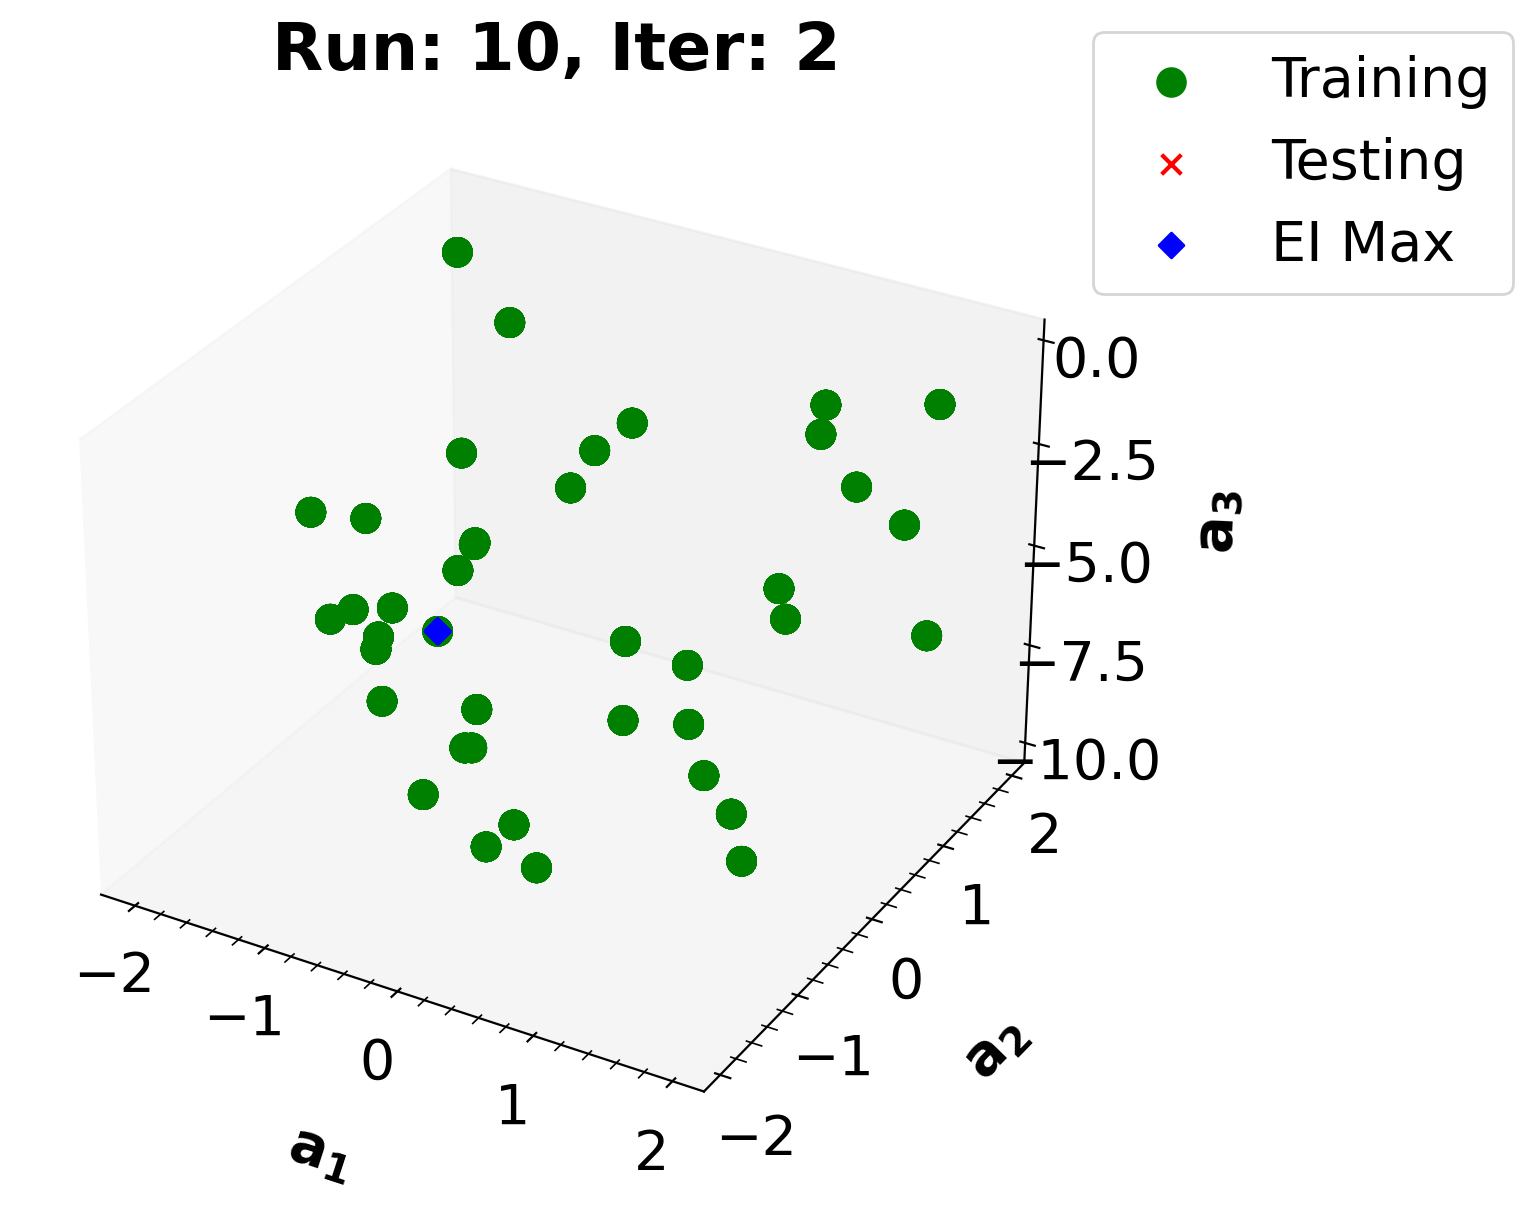

In [12]:
#Visualize training data
title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
zbins = 5
save_path = None
print(file_path)

idcs_to_plot = [0, 1, 2]
title = "Run: " + str(run_num + 1) + ", Iter: " + str(bo_iter + 1)
train_data, test_data, val_data, x_exp, data_names, data_true = analyze_train_test(file_path, run_num +1 , bo_iter+1)
train_data = train_data[:-25]  #Remove last point
max_ei_theta = loaded_results[run_num].results_df["Theta Max EI"].iloc[bo_iter]
max_ei_theta = driver.create_data_instance_from_theta(max_ei_theta)
max_ei_theta = gp_emulator.featurize_data(max_ei_theta)

print("Max EI Theta", loaded_results[run_num].results_df["Theta Max EI"].iloc[bo_iter])

plot_train_test_val_data(train_data, test_data, max_ei_theta, data_names, idcs_to_plot, x_exp, xbins, ybins, zbins, 
                         title, title_fontsize, other_fontsize, save_path)

In [8]:
#Print all Max EI Thetas for that run 
train_start = loaded_results[run_num].list_gp_emulator_class[0].feature_train_data
train_end = loaded_results[run_num].list_gp_emulator_class[-1].feature_train_data
len_ei = len(train_end) - len(train_start)
train_ei = train_end[-len_ei-1:-1]
print(len(train_ei))

25


In [9]:
unique_indexes = np.unique(train_ei[:,0:-2], axis = 0, return_index=True)[1]
unique_vals = np.array([train_ei[index] for index in sorted(unique_indexes)])[:,0:-2]

In [10]:
print(unique_vals)

[[-0.53762385 -1.54209214 -3.91624606  1.1544071 ]
 [-1.52838065  0.76858661 -8.32826196 -0.15766997]]


In [ ]:
# np.savetxt("trial.csv", unique_vals, delimiter=",")